# Import libs

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import openai
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import OxfordIIITPet
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import logging
import clip
import json
openai.api_key  = os.getenv('OPENAI_API_KEY')
from collections import OrderedDict
import numpy as np
from tqdm import tqdm

# Load Dataset using the Mean and std dev of training dataset

In [2]:
oxfordpet_path = '/home/kush/Desktop/CLIP/'
transform = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.4827, 0.4472, 0.3974), (0.2289, 0.2260, 0.2275)),
])
oxfordpet_dataset_train = OxfordIIITPet(oxfordpet_path, split="trainval", transform = transform)
oxfordpet_dataset_test = OxfordIIITPet(oxfordpet_path, split="test", transform = transform)

/home/kush/anaconda3/envs/kush/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [3]:
oxfordpet_dataset_train.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

# Change Class names -> They are not proper

In [4]:
def get_full_class_labels(file_path):
    classes_full_names = set()
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            class_id, _, species, _ = line.strip('\n').split(' ', 3)
            class_id = ' '.join(class_id.split('_')[0: -1]).title()
            if int(species) == 1:
                class_id += ' Cat'
            else:
                class_id += ' Dog'
            classes_full_names.add(class_id)
    return classes_full_names

In [5]:
def fix_class_names(dataset, complete_class_names):
    for class_name in complete_class_names:
        incomplete_class_name = ' '.join(class_name.split(' ')[0: -1]).strip()
        find_index = lambda l, x: l.index(x) if x in l else -1
        index_of_incorrect_class = find_index(dataset.classes, incomplete_class_name)
        if index_of_incorrect_class != -1:
            dataset.classes[index_of_incorrect_class] = class_name
        idx = dataset.class_to_idx.pop(incomplete_class_name, -1)
        if idx != -1:
            dataset.class_to_idx[class_name] = idx

In [6]:
list_txt_path = 'oxford-iiit-pet/annotations/list.txt'
full_class_labels = get_full_class_labels(os.path.join(oxfordpet_path,list_txt_path))
fix_class_names(oxfordpet_dataset_train, full_class_labels)
fix_class_names(oxfordpet_dataset_test, full_class_labels)
print(oxfordpet_dataset_train.classes)
print(oxfordpet_dataset_train.class_to_idx)

['Abyssinian Cat', 'American Bulldog Dog', 'American Pit Bull Terrier Dog', 'Basset Hound Dog', 'Beagle Dog', 'Bengal Cat', 'Birman Cat', 'Bombay Cat', 'Boxer Dog', 'British Shorthair Cat', 'Chihuahua Dog', 'Egyptian Mau Cat', 'English Cocker Spaniel Dog', 'English Setter Dog', 'German Shorthaired Dog', 'Great Pyrenees Dog', 'Havanese Dog', 'Japanese Chin Dog', 'Keeshond Dog', 'Leonberger Dog', 'Maine Coon Cat', 'Miniature Pinscher Dog', 'Newfoundland Dog', 'Persian Cat', 'Pomeranian Dog', 'Pug Dog', 'Ragdoll Cat', 'Russian Blue Cat', 'Saint Bernard Dog', 'Samoyed Dog', 'Scottish Terrier Dog', 'Shiba Inu Dog', 'Siamese Cat', 'Sphynx Cat', 'Staffordshire Bull Terrier Dog', 'Wheaten Terrier Dog', 'Yorkshire Terrier Dog']
{'British Shorthair Cat': 9, 'Keeshond Dog': 18, 'Yorkshire Terrier Dog': 36, 'Russian Blue Cat': 27, 'German Shorthaired Dog': 14, 'Basset Hound Dog': 3, 'Great Pyrenees Dog': 15, 'Shiba Inu Dog': 31, 'Egyptian Mau Cat': 11, 'Bombay Cat': 7, 'Newfoundland Dog': 22, 'Per

# Calc mean and std dev from training DS

In [7]:
# mean = torch.zeros(3)
# std_dev = torch.zeros(3)

# for img, _ in oxfordpet_dataset:
#     mean += img.mean(dim=(1, 2))
#     std_dev += img.std(dim=(1, 2))
# mean /= len(oxfordpet_dataset)
# std_dev /= len(oxfordpet_dataset)
# print("Mean values:", mean)
# print("Std Dev values:", std_dev)

# Load model

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [35]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

# Function for index to label

In [36]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [37]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [38]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [39]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx].squeeze()))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

# Calculate CLIP accuracy

In [15]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        top5_values, top5_indices = image_labels_similarity.topk(5, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_top5 = clip_accuracy_metric_top5(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, top5_indices)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs["Total CLIP-Standard Top-5 Accuracy: "] = 100*clip_accuracy_metric_top5.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        # Write JSON string to a text file
        with open(f'oxpet_top{topK}.json', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [40]:
calc_acc(model, oxfordpet_dataset_test, oxfordpet_dataset_test.classes,
         count_classes = False)

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 79.85827326774597,
 'Total CLIP-Standard Top-5 Accuracy: ': 96.21149897575378}

# Graphs

In [17]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


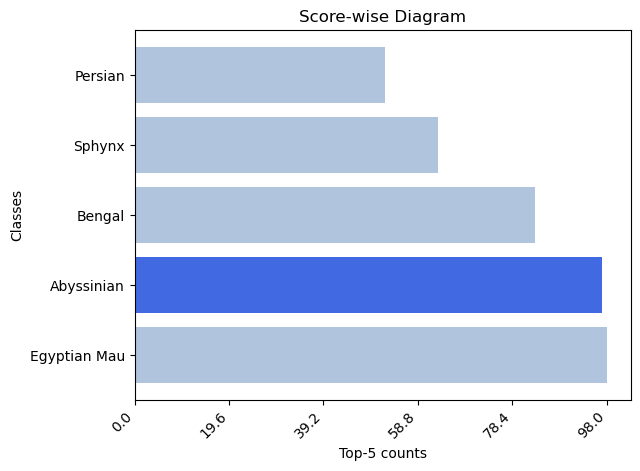

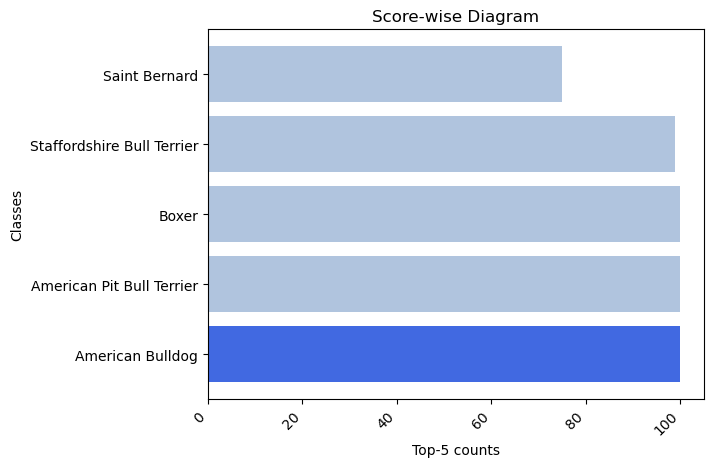

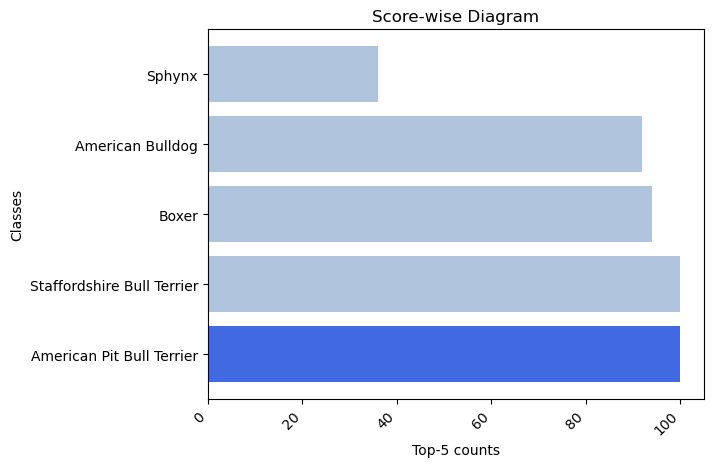

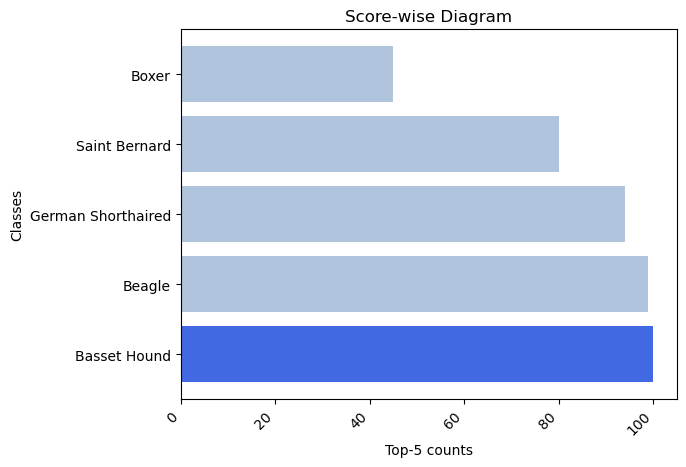

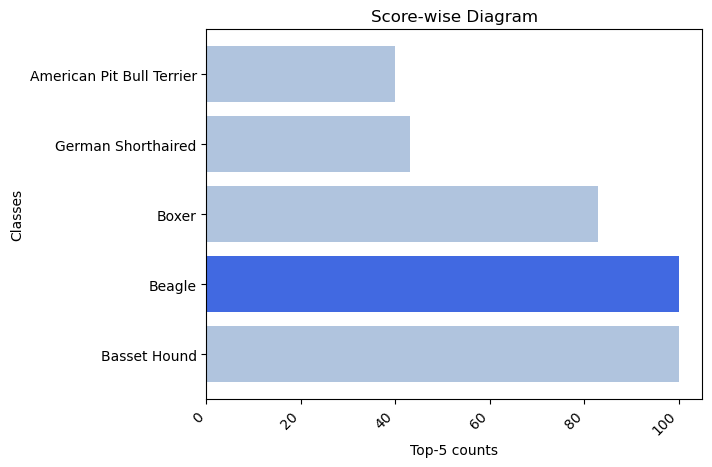

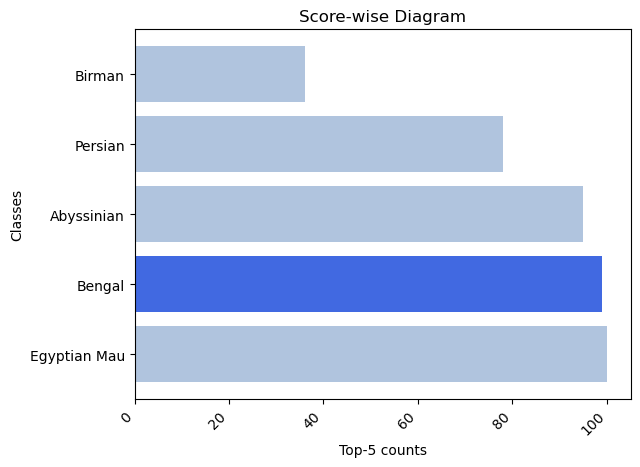

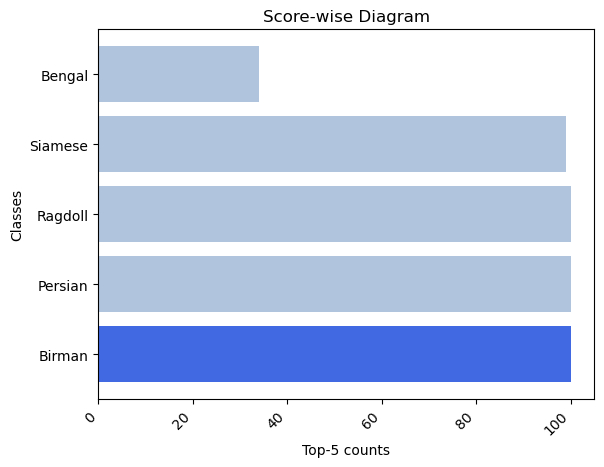

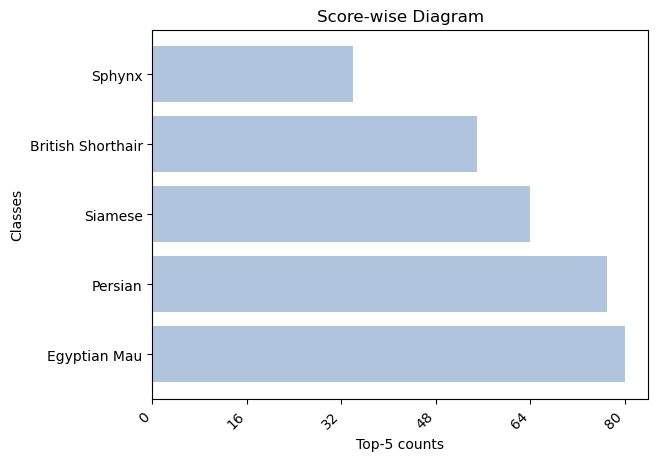

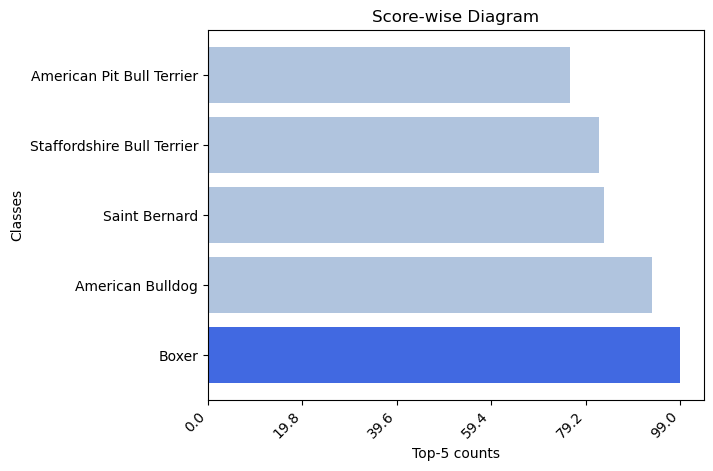

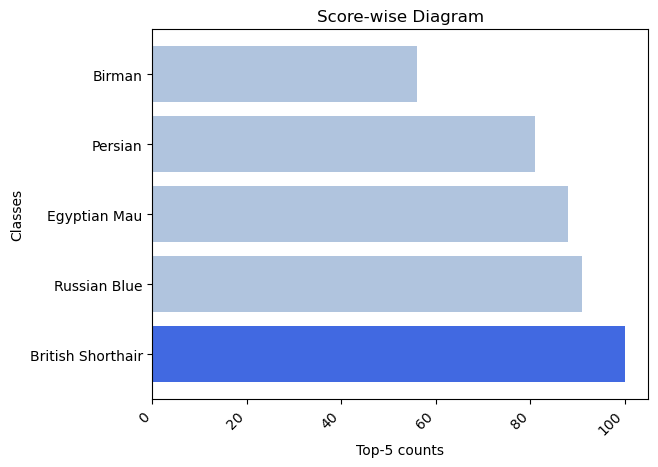

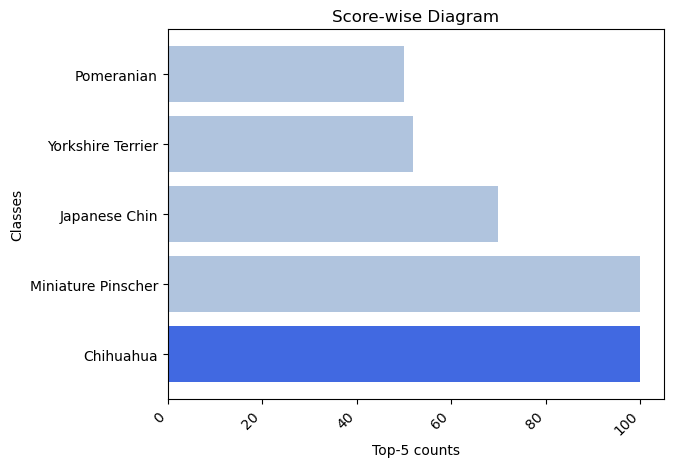

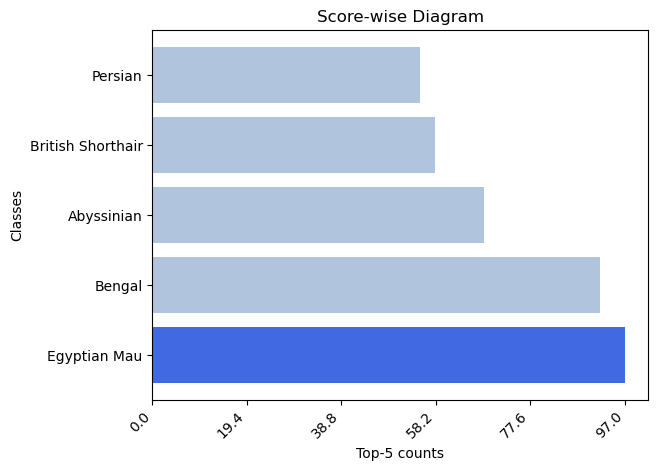

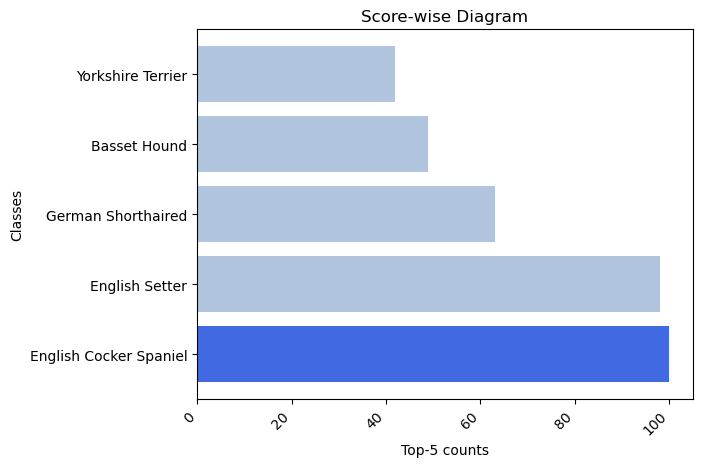

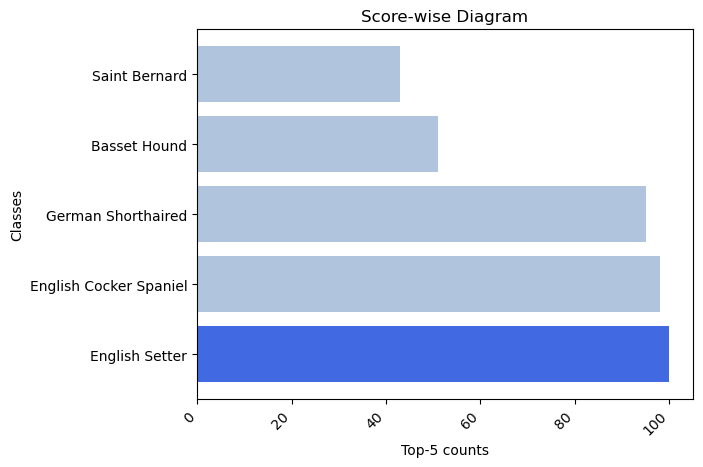

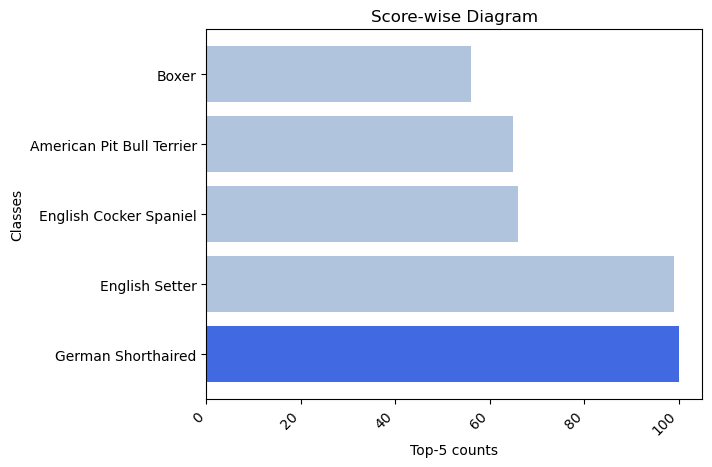

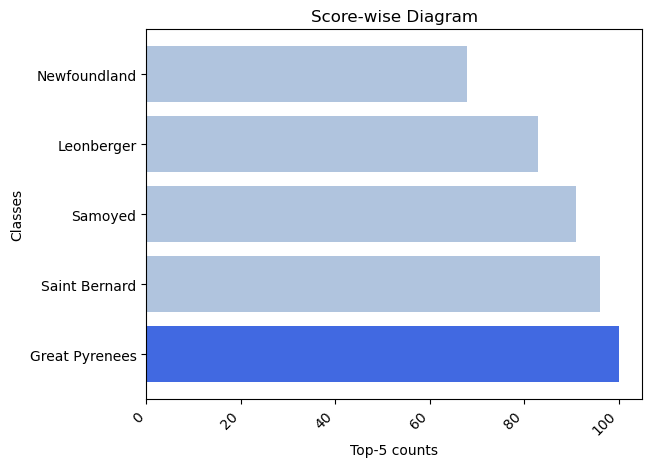

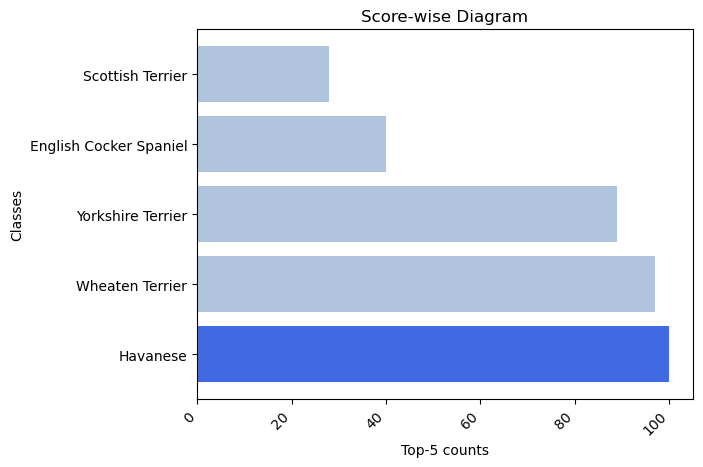

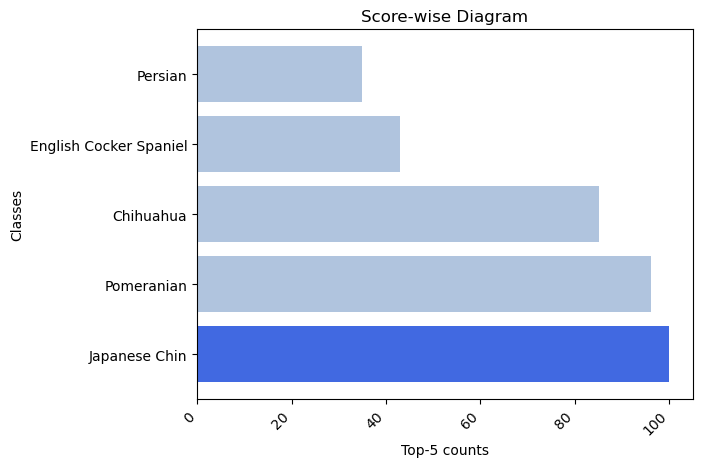

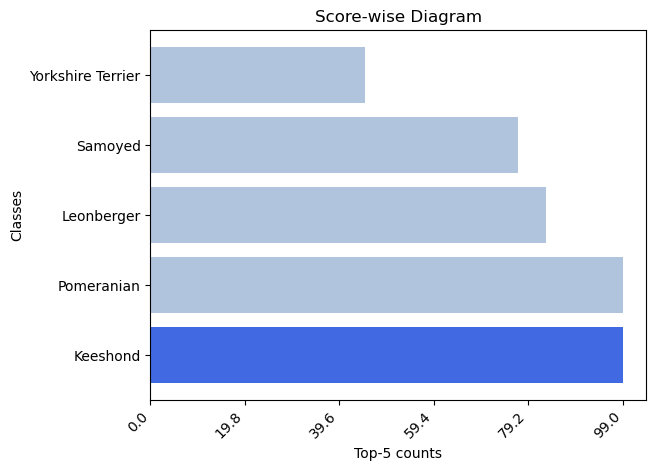

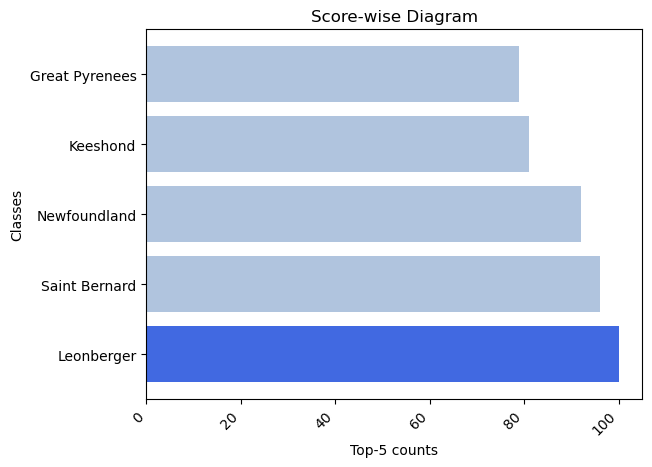

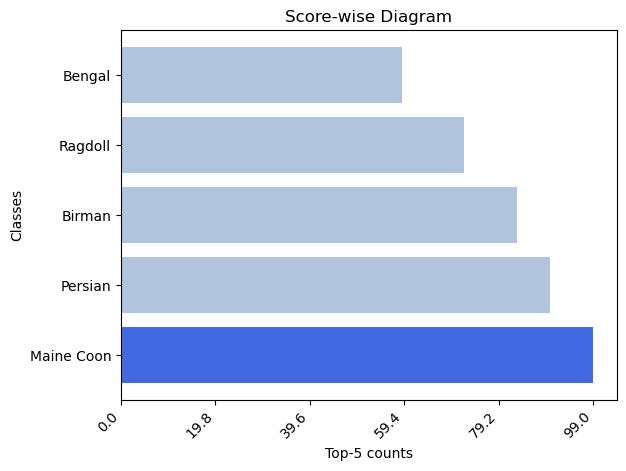

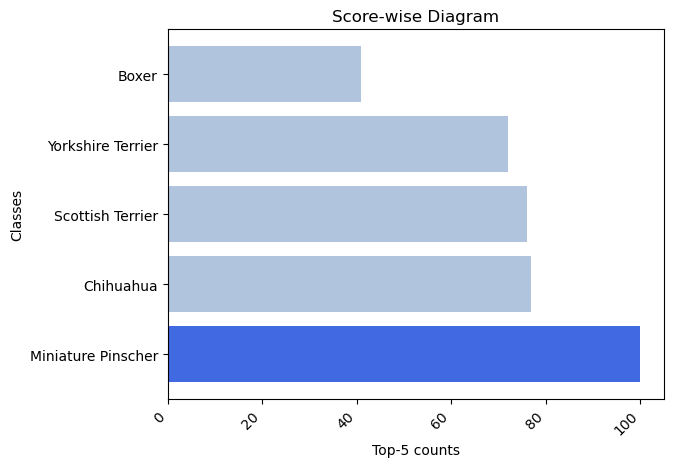

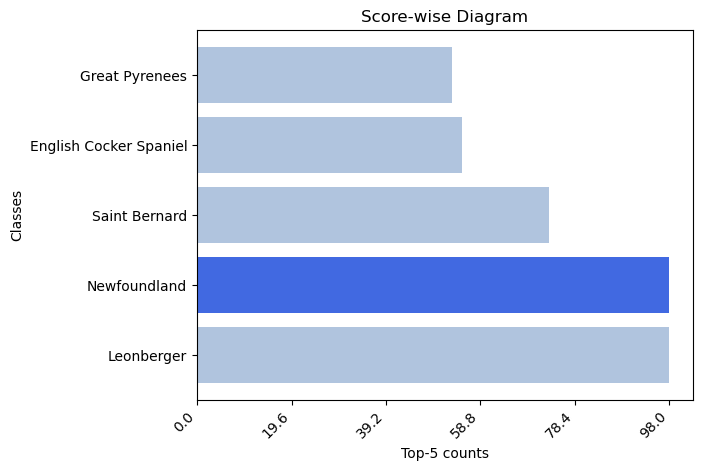

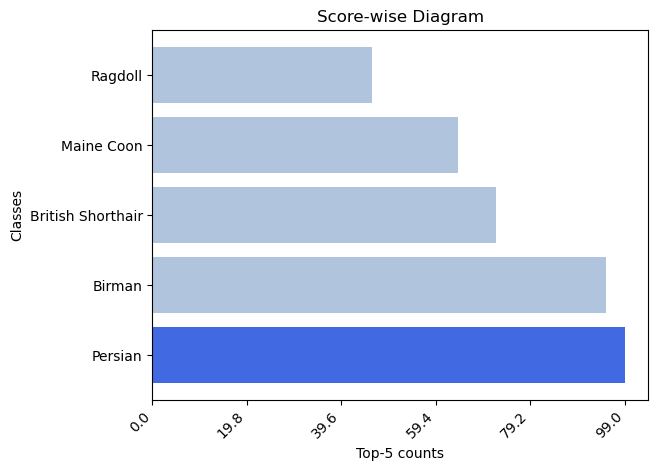

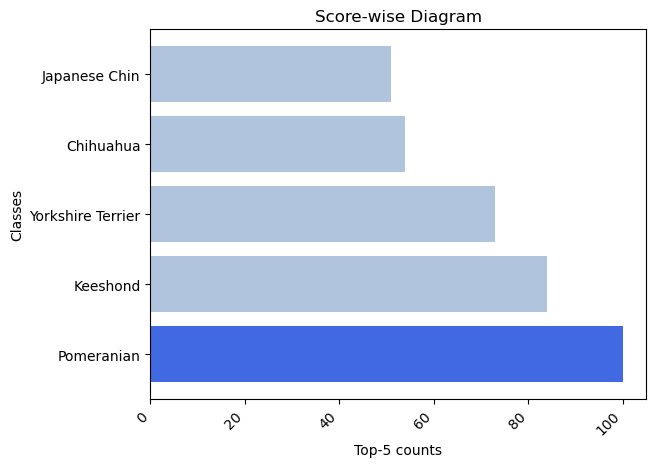

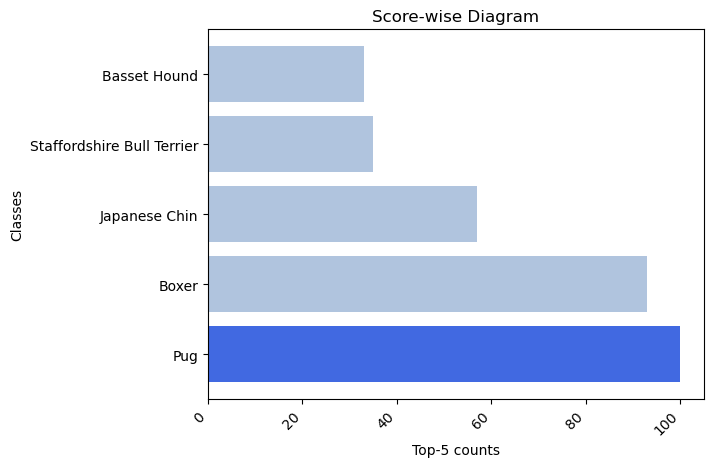

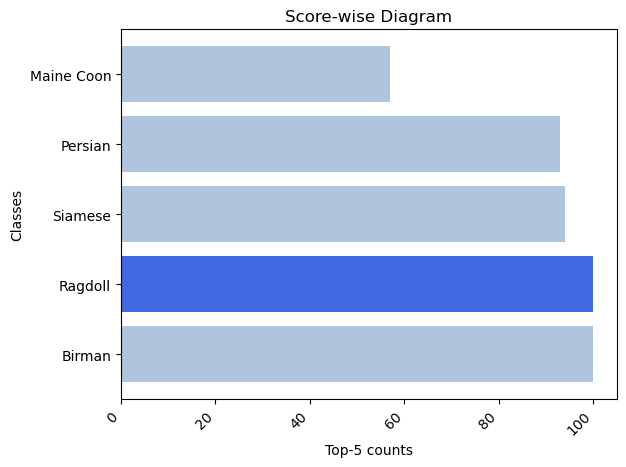

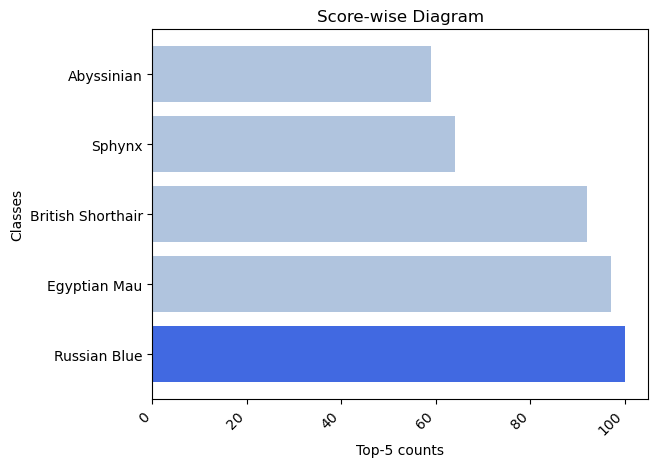

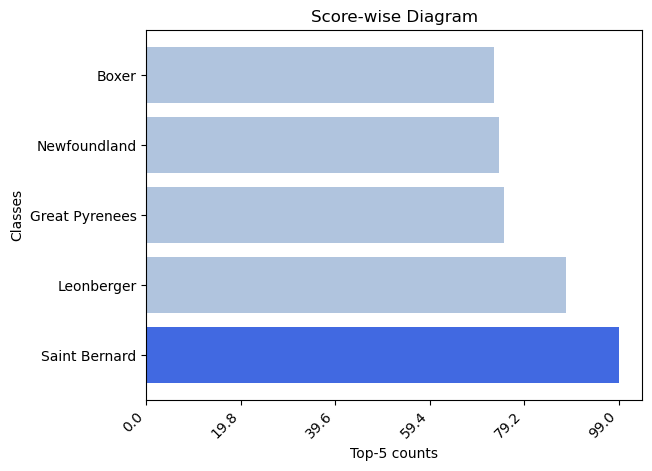

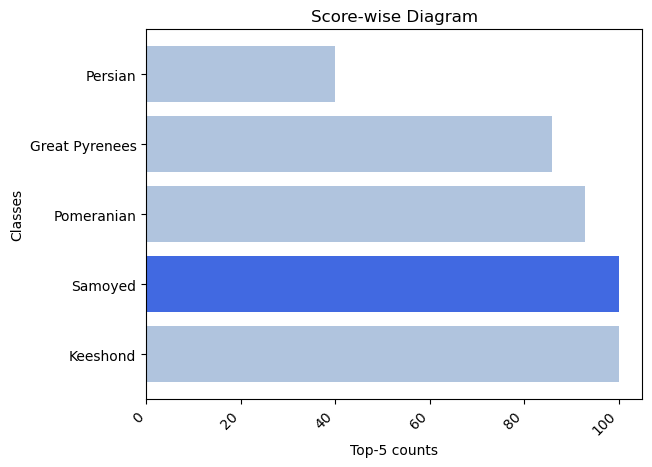

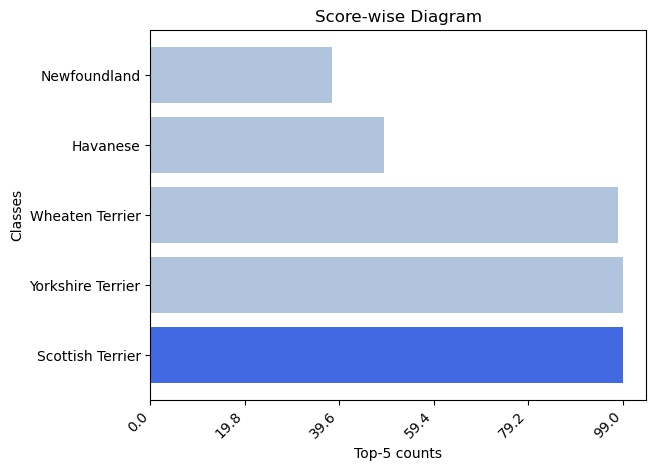

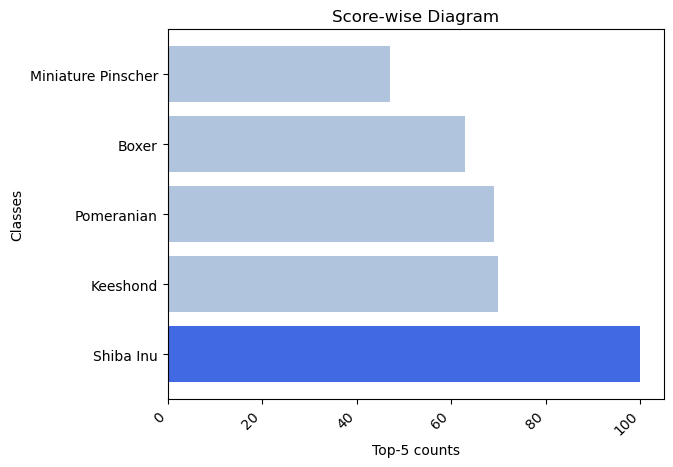

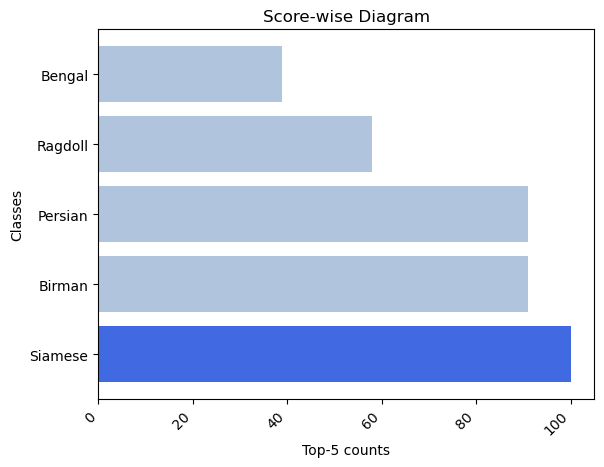

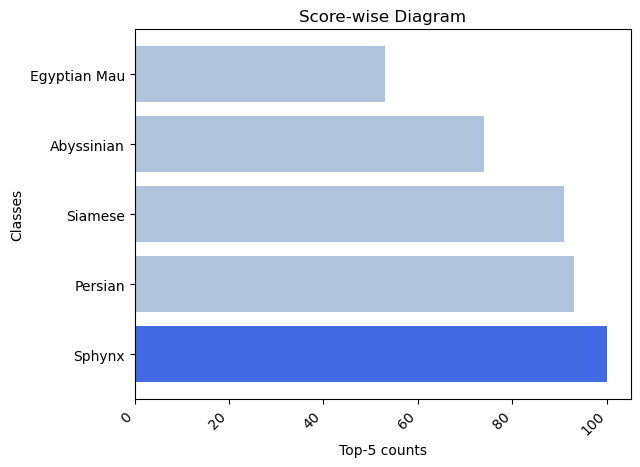

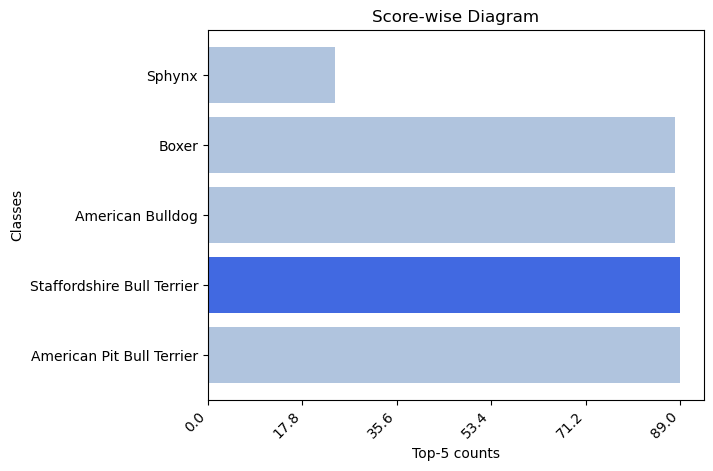

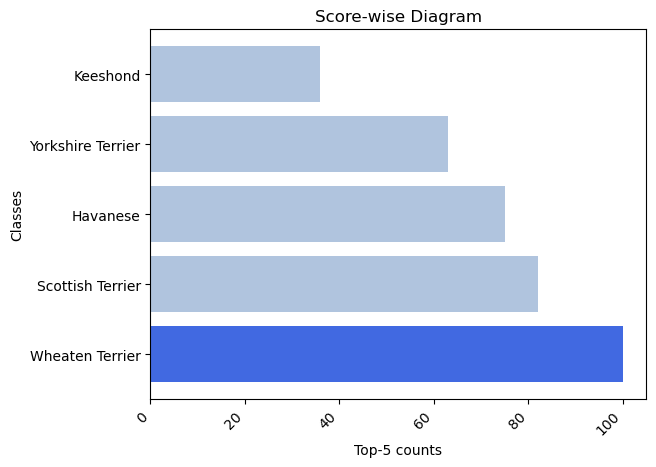

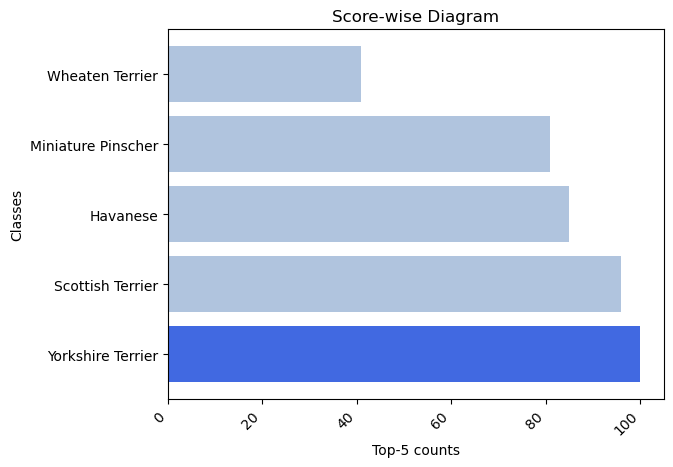

In [18]:
with open('oxpet_top5.json', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

In [19]:
top5[class_][0:5]

[['Yorkshire Terrier', 100],
 ['Scottish Terrier', 96],
 ['Havanese', 85],
 ['Miniature Pinscher', 81],
 ['Wheaten Terrier', 41]]

# Calc Top-5 using labels

# Create Attributes of Pairs from Top-5 Distribution

# Generate attributes functions

In [20]:
def logs():
    logging.basicConfig(
        level=logging.DEBUG,            # Set the minimum log level to DEBUG
        filename='gpt_3_my_cub.log',        # Specify the log file name
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    logger = logging.getLogger(__name__)
    return logger


In [21]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to generate you answers for user's query. Give the answer in a JSON format just like given in the example

    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
       A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-


        {
            "tiger": [
                     "has orange coats with vertical 'black' stripes",
                     "are generally larger and robust",
                     "often have a more rounded face with prominent cheekbones",
                     "ears are usually smaller and rounded",
                     "tails are long and have a characteristic 'white spot' at the tip",
                     "are found in a variety of habitats, including dense forests and grasslands"
                     ],

            "lion": [
                    "typically have a tawny or 'beige coat', and their fur is often smoother and they have a mane",
                    "has a more compact and muscular build",
                    "lions may have a more squared-off face",
                    "ears are large and often have a more pointed shape",
                    "tails are shorter, ending in a tuft of hair",
                    "habitats are savannas and open woodlands"
                    ]
        }
        ```
    Remember not to use the first class name in the response of second class and vice-a-versa. For example here, in the answer for tiger do not use lion and in answer for lion do not use the word tiger.
"""},
    {"role": "user", "content": prompt}]
    
    try:
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]

# Create Attributes of Pairs from Top-5 Distribution

In [22]:
def generate_attributes(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
    print(prompt)
    response = get_completion(prompt, logger)
#     response = get_completion_dummy(prompt)
    answer = response
    print(response)
    
    return answer

In [23]:
def generate_attributes_dummy(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
#     print(prompt)
    return """aasdasd
    asfasfasfdas
    {
    "Laysan Albatross": [
    "have a white head and neck with a dark eye patch",
    "have a black upperwing with a white trailing edge",
    "underside is mostly white with dark edges on the underwing",
    "have a pink bill with a dark tip",
    "are generally medium-sized with a wingspan of around 6 feet",
    "nest in the Northwestern Hawaiian Islands"
    ],

    "Sooty Albatross": [
        "have a dark plumage overall, including the head and neck",
        "have a uniformly dark upperwing without a distinct pattern",
        "underside is dark, often with paler edges on the underwing",
        "have a dark bill without significant markings",
        "are larger in size with a wingspan of around 7 feet",
        "nest on sub-Antarctic islands and some isolated islands in the Southern Ocean"
    ]
    }sfsdfsdfsdf"""

In [24]:
def process_response(response):
    try:
        json_response = response
        json.loads(json_response)
    except Exception as e:
        lines = response.split('\n')
        json_response = ''
        for index, line in enumerate(lines):
            if line.find('{') != -1:
                json_response = line[line.find('{'):] + "\n"
                index += 1
                while index < len(lines) and lines[index].find('}') == -1:
                    json_response += lines[index]
                    index += 1
                if index < len(lines) and lines[index].find('}') != -1:
                    json_response += lines[index][:lines[index].find('}')+1]
                    break
                else:
                    html_string = f'<font color="red">{str(response)}</font>'
                    display(HTML(html_string))
    return json.loads(json_response)

In [25]:
def convert_to_json(dict_set):
    json_dict = dict_set.copy()
    for key in dict_set.keys():
        json_dict[key] = list(dict_set[key])
    return json.dumps(json_dict, indent=4)

In [26]:
descriptor_dict = dict()

In [29]:
already_seen = set()
total_pairs = 0

for class_ in tqdm(top5.keys()):
    number_of_pairs = 0
    for top_class, count in top5[class_][0:5]:
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5:
            continue
        response = generate_attributes(class_, top_class)
        try:
            json_response = process_response(response)
            keys = list(json_response.keys())
            fixed_json_response = dict()
            fixed_json_response[class_] = json_response[keys[0]]
            fixed_json_response[top_class] = json_response[keys[1]]
        except:
            print("Could not process the input, continue...")
            continue
        if class_ in descriptor_dict:
            descriptor_dict[class_] |= set(fixed_json_response[class_])
        else:
            descriptor_dict[class_] = set(fixed_json_response[class_])
        if top_class in descriptor_dict:
            descriptor_dict[top_class] |= set(fixed_json_response[top_class])
        else:
            descriptor_dict[top_class] = set(fixed_json_response[top_class])
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1
        
        descriptor_json = convert_to_json(descriptor_dict)
                
        with open(f'oxpet_descriptors.json', 'w') as file:
            file.write(descriptor_json)
    

  0%|                                                    | 0/37 [00:00<?, ?it/s]


    Q: What are useful features for distinguishing a Abyssinian from Egyptian Mau in a photo?
    A: There are several useful visual features to tell the difference between a Abyssinian and a Egyptian Mau in a photo
    
{
    "Abyssinian": [
        "has a short, ticked coat with a warm reddish-brown color",
        "has a slender and athletic build",
        "has almond-shaped eyes that are usually green or gold",
        "ears are large and pointed",
        "tail is long and tapering",
        "has a distinctive 'M' marking on the forehead"
    ],
    "Egyptian Mau": [
        "has a spotted coat with a silver or bronze background color",
        "has a medium-sized and muscular build",
        "has large, almond-shaped eyes that are usually green",
        "ears are medium-sized and slightly rounded",
        "tail is medium-length and tapering",
        "has a distinctive 'M' marking on the forehead"
    ]
}

    Q: What are useful features for distinguishing a Abyssinian from B

  3%|█▏                                          | 1/37 [00:53<32:23, 53.99s/it]

{
    "Abyssinian": [
        "has a short, ticked coat with bands of color on each hair",
        "usually has a slender and athletic build",
        "ears are large and pointed",
        "eyes are almond-shaped and usually green or gold",
        "tail is long and tapering"
    ],
    "Persian": [
        "typically has a long, thick coat that comes in a variety of colors",
        "has a stocky and round body",
        "ears are small and rounded",
        "eyes are large and round",
        "tail is short and fluffy"
    ]
}

    Q: What are useful features for distinguishing a American Bulldog from American Pit Bull Terrier in a photo?
    A: There are several useful visual features to tell the difference between a American Bulldog and a American Pit Bull Terrier in a photo
    
{
    "American Bulldog": [
        "has a large, muscular build",
        "typically has a broad head with a square-shaped muzzle",
        "ears are usually medium-sized and can be either rose-shaped or 

  5%|██▍                                         | 2/37 [01:42<29:35, 50.74s/it]

{
    "American Bulldog": [
        "has a muscular build with a broad chest and strong legs",
        "typically has a short coat that can be white, brindle, or a combination of both",
        "has a square-shaped head with a strong jawline",
        "ears are usually medium-sized and can be either cropped or left natural",
        "has a short, stubby tail",
        "is generally smaller in size compared to a Saint Bernard"
    ],
    "Saint Bernard": [
        "has a large and powerful build with a deep chest and sturdy legs",
        "typically has a long, thick coat that is usually white with patches of brown, red, or brindle",
        "has a broad and rounded head with a gentle expression",
        "ears are usually medium to large in size and hang down",
        "has a long, bushy tail",
        "is generally larger in size compared to an American Bulldog"
    ]
}

    Q: What are useful features for distinguishing a American Pit Bull Terrier from Staffordshire Bull Terrier in a

  8%|███▌                                        | 3/37 [02:18<25:00, 44.12s/it]

{
    "American Pit Bull Terrier": [
        "has a muscular build with a broad chest and strong legs",
        "typically has a short coat that can come in a variety of colors",
        "has a square-shaped head with a strong jawline",
        "ears are often cropped or can be left natural and are set high on the head",
        "has a short tail that is thick at the base and tapers to a point",
        "has a confident and alert expression"
    ],
    "Sphynx": [
        "has a hairless body with wrinkled skin",
        "often has large ears that are set wide apart",
        "has a round head with prominent cheekbones",
        "eyes are large and expressive",
        "has a slender and muscular body",
        "has a long, whip-like tail"
    ]
}

    Q: What are useful features for distinguishing a Basset Hound from Beagle in a photo?
    A: There are several useful visual features to tell the difference between a Basset Hound and a Beagle in a photo
    
{
    "Basset Hound": [
    

 11%|████▊                                       | 4/37 [03:06<25:06, 45.64s/it]

{
    "Basset Hound": [
        "has a long body with short legs",
        "has droopy ears that hang low",
        "has a wrinkled face with a prominent nose",
        "has a sad expression",
        "has a short, smooth coat",
        "is generally smaller in size"
    ],
    "Boxer": [
        "has a muscular and athletic build",
        "has a square-shaped head",
        "has a short, smooth coat",
        "has a strong jaw and a powerful bite",
        "has a confident and alert expression",
        "is generally larger in size"
    ]
}

    Q: What are useful features for distinguishing a Beagle from Boxer in a photo?
    A: There are several useful visual features to tell the difference between a Beagle and a Boxer in a photo
    
{
    "Beagle": [
        "has a short, smooth coat",
        "typically has a tricolor pattern with a combination of black, white, and brown",
        "has long, droopy ears",
        "has a compact and muscular build",
        "has a friendly and al

 14%|█████▉                                      | 5/37 [03:30<20:13, 37.91s/it]

{
    "Beagle": [
        "has a short, smooth coat",
        "typically has a tricolor pattern with a combination of black, white, and brown",
        "has long, droopy ears",
        "has a compact and muscular build",
        "has a friendly and alert expression"
    ],
    "American Pit Bull Terrier": [
        "has a short, stiff coat",
        "comes in a variety of colors including brindle, fawn, and blue",
        "has a broad head and strong jaw",
        "has a muscular and athletic build",
        "has a confident and determined expression"
    ]
}

    Q: What are useful features for distinguishing a Bengal from Egyptian Mau in a photo?
    A: There are several useful visual features to tell the difference between a Bengal and a Egyptian Mau in a photo
    
{
    "Bengal": [
        "has a distinctive spotted or marbled coat pattern",
        "often has a sleek and muscular build",
        "ears are medium-sized and have a rounded tip",
        "eyes are usually large and a

 16%|███████▏                                    | 6/37 [04:06<19:06, 36.99s/it]

{
    "Bengal": [
        "has a distinctive spotted or marbled coat pattern",
        "often has a more muscular and athletic build",
        "ears are medium-sized and have a rounded tip",
        "eyes are usually almond-shaped and can be green or gold",
        "coat colors can range from brown to orange with black markings",
        "are known for their energetic and playful nature"
    ],
    "Birman": [
        "has a silky and semi-longhaired coat",
        "typically has a more medium-sized and stocky build",
        "ears are medium-sized and have a rounded tip",
        "eyes are usually large and round and are usually blue",
        "coat colors are usually lighter with darker points on the ears, face, paws, and tail",
        "are known for their gentle and affectionate nature"
    ]
}

    Q: What are useful features for distinguishing a Birman from Persian in a photo?
    A: There are several useful visual features to tell the difference between a Birman and a Persian in

 19%|████████▎                                   | 7/37 [04:45<18:52, 37.75s/it]

{
    "Birman": [
        "has a medium-sized body with a sturdy build",
        "has a silky, medium-length coat that is usually light in color",
        "has striking blue eyes",
        "has a distinctive color pattern on the face, with darker shades around the eyes and ears",
        "has white paws that resemble gloves",
        "has a gentle and calm expression"
    ],
    "Siamese": [
        "has a slender and elegant body",
        "has a short and fine coat that is usually light in color with darker points on the ears, face, paws, and tail",
        "has striking blue eyes",
        "has a triangular-shaped face with a straight profile",
        "has a vocal and outgoing personality",
        "has a more angular and sleek appearance compared to the Birman"
    ]
}

    Q: What are useful features for distinguishing a Bombay from Egyptian Mau in a photo?
    A: There are several useful visual features to tell the difference between a Bombay and a Egyptian Mau in a photo
    
{

 22%|█████████▌                                  | 8/37 [05:38<20:34, 42.57s/it]

{
    "Bombay": [
        "has a sleek and shiny black coat",
        "has a muscular and medium-sized body",
        "has round and expressive copper or gold eyes",
        "has a short and straight nose",
        "has small and rounded ears",
        "has a short and thick tail"
    ],
    "Sphynx": [
        "has little to no hair on its body",
        "has a wrinkled and soft skin",
        "has a medium-sized and muscular body",
        "has large and lemon-shaped eyes",
        "has a long and slender nose",
        "has large and wide-set ears",
        "has a long and whip-like tail"
    ]
}

    Q: What are useful features for distinguishing a Boxer from Saint Bernard in a photo?
    A: There are several useful visual features to tell the difference between a Boxer and a Saint Bernard in a photo
    
{
    "Boxer": [
        "has a short coat that is smooth and shiny",
        "typically has a muscular and athletic build",
        "ears are medium-sized and can be either cropp

 24%|██████████▋                                 | 9/37 [06:00<16:49, 36.07s/it]

{
    "Boxer": [
        "has a square-shaped head with a strong jawline",
        "ears are set high on the head and can be cropped or left natural",
        "has a short coat that is smooth and shiny",
        "typically has a brindle or fawn coat color",
        "has a muscular build with a deep chest and strong legs",
        "often has a docked tail"
    ],
    "Staffordshire Bull Terrier": [
        "has a broad head with a short muzzle",
        "ears are set high on the head and can be cropped or left natural",
        "has a short coat that is smooth and dense",
        "typically has a coat color of red, fawn, white, black, or blue",
        "has a stocky and muscular build",
        "has a natural tail that is medium in length"
    ]
}

    Q: What are useful features for distinguishing a British Shorthair from Russian Blue in a photo?
    A: There are several useful visual features to tell the difference between a British Shorthair and a Russian Blue in a photo
    
{
    "

 27%|███████████▌                               | 10/37 [06:39<16:38, 36.99s/it]

{
    "British Shorthair": [
        "has a round face with chubby cheeks",
        "has a dense and plush coat",
        "comes in a variety of colors and patterns",
        "has a sturdy and muscular build",
        "has round and large eyes",
        "has a short and thick tail"
    ],
    "Birman": [
        "has a semi-long and silky coat",
        "has a colorpoint pattern with darker points on the ears, face, paws, and tail",
        "has a medium-sized body with a muscular build",
        "has a round face with a Roman nose",
        "has striking blue eyes",
        "has a plume-like tail"
    ]
}

    Q: What are useful features for distinguishing a Chihuahua from Miniature Pinscher in a photo?
    A: There are several useful visual features to tell the difference between a Chihuahua and a Miniature Pinscher in a photo
    
{
    "Chihuahua": [
        "typically have a smaller size and lighter build",
        "have a rounded apple-shaped head",
        "ears are large and st

 30%|████████████▊                              | 11/37 [07:22<16:54, 39.03s/it]

{
    "Chihuahua": [
        "typically have a smaller size and are more delicate in appearance",
        "have a rounded head with large, round eyes",
        "ears are usually large and stand upright",
        "coat can be short or long, and comes in a variety of colors",
        "have a more slender and elongated body shape"
    ],
    "Pomeranian": [
        "usually have a larger size and are more fluffy in appearance",
        "have a fox-like face with small, almond-shaped eyes",
        "ears are usually small and stand upright",
        "coat is thick and double-layered, often with a lion-like mane around the neck",
        "have a more compact and sturdy body shape"
    ]
}

    Q: What are useful features for distinguishing a Egyptian Mau from Persian in a photo?
    A: There are several useful visual features to tell the difference between a Egyptian Mau and a Persian in a photo
    


 32%|█████████████▉                             | 12/37 [07:31<12:23, 29.75s/it]

{
    "Egyptian Mau": [
        "has a short, sleek coat with spots or stripes",
        "often has a distinctive 'M' marking on its forehead",
        "ears are large and alert",
        "eyes are almond-shaped and can be green or gold",
        "body is muscular and athletic",
        "tail is medium-length and tapers to a point"
    ],
    "Persian": [
        "has a long, fluffy coat that requires regular grooming",
        "often has a flat face with a short nose",
        "ears are small and rounded",
        "eyes are large and round, usually blue or copper",
        "body is stocky and compact",
        "tail is short and bushy"
    ]
}

    Q: What are useful features for distinguishing a English Cocker Spaniel from English Setter in a photo?
    A: There are several useful visual features to tell the difference between a English Cocker Spaniel and a English Setter in a photo
    
{
    "English Cocker Spaniel": [
        "has a medium-sized body with a compact build",
       

 35%|███████████████                            | 13/37 [08:18<13:57, 34.90s/it]

{
    "English Cocker Spaniel": [
        "has a medium-sized body with a sturdy build",
        "has long, droopy ears that hang down",
        "has a long, silky coat that can be various colors including black, liver, or golden",
        "often has a rounded head with a defined stop",
        "has a long, feathered tail that is usually docked",
        "has a friendly and intelligent expression"
    ],
    "Yorkshire Terrier": [
        "has a small and compact body",
        "has small, erect ears that stand up",
        "has a long, silky coat that is blue and tan in color",
        "often has a flat skull with a medium stop",
        "has a docked tail that is carried high",
        "has a confident and alert expression"
    ]
}

    Q: What are useful features for distinguishing a English Setter from German Shorthaired in a photo?
    A: There are several useful visual features to tell the difference between a English Setter and a German Shorthaired in a photo
    
{
    "English

 38%|████████████████▎                          | 14/37 [08:49<12:56, 33.78s/it]

{
    "English Setter": [
        "has a medium-sized build with a lean and athletic body",
        "has a long and silky coat that is usually white with patches of color, such as orange, black, or liver",
        "has long and floppy ears that hang down",
        "has a long and slender tail",
        "has a more elegant and graceful appearance"
    ],
    "Saint Bernard": [
        "has a large and heavy build with a strong and muscular body",
        "has a short and dense coat that is usually white with patches of color, such as red, brindle, or mahogany",
        "has large and droopy ears that hang down",
        "has a thick and bushy tail",
        "has a more powerful and sturdy appearance"
    ]
}

    Q: What are useful features for distinguishing a German Shorthaired from American Pit Bull Terrier in a photo?
    A: There are several useful visual features to tell the difference between a German Shorthaired and a American Pit Bull Terrier in a photo
    
{
    "German Short

 41%|█████████████████▍                         | 15/37 [09:11<11:09, 30.43s/it]

{
    "German Shorthaired": [
        "has a short, dense coat that is usually liver or liver and white in color",
        "are medium-sized dogs with a lean and athletic build",
        "have a more pointed muzzle and a slightly arched skull",
        "ears are set high and are medium in size, hanging down close to the head",
        "tails are usually docked to a medium length",
        "are known for their hunting abilities and are often used as gun dogs"
    ],
    "Boxer": [
        "has a short, smooth coat that can be fawn or brindle in color",
        "are medium to large-sized dogs with a muscular build",
        "have a square-shaped head with a strong jaw",
        "ears are set high and are usually cropped to stand erect",
        "tails are usually docked to a short length",
        "are known for their playful and energetic nature"
    ]
}

    Q: What are useful features for distinguishing a Great Pyrenees from Saint Bernard in a photo?
    A: There are several useful vi

 43%|██████████████████▌                        | 16/37 [09:57<12:16, 35.06s/it]

{
    "Great Pyrenees": [
        "has a thick, white double coat",
        "often has a more rounded face with a gentle expression",
        "ears are medium-sized and hang down close to the head",
        "has a long, fluffy tail that hangs down",
        "typically has a larger size and a more elegant build"
    ],
    "Newfoundland": [
        "has a thick, water-resistant double coat that can be black, brown, or gray",
        "often has a more square-shaped face with a serious expression",
        "ears are large and hang down close to the head",
        "has a long, heavy tail that hangs down",
        "typically has a larger size and a more muscular build"
    ]
}

    Q: What are useful features for distinguishing a Havanese from Wheaten Terrier in a photo?
    A: There are several useful visual features to tell the difference between a Havanese and a Wheaten Terrier in a photo
    
{
    "Havanese": [
        "has a long, silky coat that comes in a variety of colors including

 46%|███████████████████▊                       | 17/37 [10:35<11:57, 35.85s/it]

{
    "Havanese": [
        "has a long, silky coat that comes in a variety of colors",
        "has a small, compact body with a slightly rounded head",
        "ears are set high on the head and are usually folded over",
        "has a short, straight tail that is carried high",
        "has a friendly and alert expression"
    ],
    "Scottish Terrier": [
        "has a wiry, dense coat that is usually black or brindle in color",
        "has a sturdy and muscular build",
        "has a distinctive head shape with a strong jaw and bushy eyebrows",
        "ears are small and erect",
        "has a short tail that is carried straight or slightly curved"
    ]
}

    Q: What are useful features for distinguishing a Japanese Chin from Pomeranian in a photo?
    A: There are several useful visual features to tell the difference between a Japanese Chin and a Pomeranian in a photo
    
{
    "Japanese Chin": [
        "has a small, compact body",
        "has a flat face with a short muzz

 49%|████████████████████▉                      | 18/37 [11:03<10:39, 33.67s/it]

{
    "Japanese Chin": [
        "has a small, compact body",
        "has a flat face with a short nose",
        "ears are large and set high on the head",
        "eyes are large and round",
        "coat is typically long and silky",
        "tail is plumed and carried over the back"
    ],
    "Persian": [
        "has a medium to large body",
        "has a round face with a short nose",
        "ears are small and set low on the head",
        "eyes are large and round",
        "coat is long and thick",
        "tail is bushy and carried low"
    ]
}

    Q: What are useful features for distinguishing a Keeshond from Pomeranian in a photo?
    A: There are several useful visual features to tell the difference between a Keeshond and a Pomeranian in a photo
    
{
    "Keeshond": [
        "has a thick double coat with a dense undercoat",
        "typically has a longer and more abundant fur",
        "often has a distinct ruff around the neck",
        "ears are medium-sized and

 51%|██████████████████████                     | 19/37 [11:44<10:44, 35.79s/it]

{
    "Keeshond": [
        "has a thick double coat with a dense undercoat",
        "typically has a wolf-like face with a pointed snout",
        "ears are medium-sized and stand erect",
        "has a plumed tail that curls over the back",
        "usually has a gray or black coat with distinct markings on the face and legs"
    ],
    "Yorkshire Terrier": [
        "has a long, silky coat that is typically tan and blue",
        "has a small and compact body",
        "typically has a flat face with a short snout",
        "ears are small and stand erect",
        "has a docked tail that is carried high"
    ]
}

    Q: What are useful features for distinguishing a Leonberger from Saint Bernard in a photo?
    A: There are several useful visual features to tell the difference between a Leonberger and a Saint Bernard in a photo
    
{
    "Leonberger": [
        "has a thick, double coat that is usually a combination of yellow, red, and brown",
        "has a large, broad head with

 54%|███████████████████████▏                   | 20/37 [12:06<08:57, 31.63s/it]

{
    "Leonberger": [
        "has a thick, double coat that is usually a golden or red color",
        "has a large, broad head with a pronounced forehead",
        "ears are medium-sized and hang down close to the head",
        "has a long, bushy tail that hangs down when at rest",
        "typically has a more elegant and graceful appearance"
    ],
    "Newfoundland": [
        "has a thick, water-resistant double coat that is usually black, brown, or gray",
        "has a large, broad head with a square-shaped muzzle",
        "ears are medium-sized and hang down close to the head",
        "has a long, thick tail that hangs down when at rest",
        "typically has a more sturdy and powerful appearance"
    ]
}

    Q: What are useful features for distinguishing a Maine Coon from Persian in a photo?
    A: There are several useful visual features to tell the difference between a Maine Coon and a Persian in a photo
    
{
    "Maine Coon": [
        "has a large and muscular bui

 57%|████████████████████████▍                  | 21/37 [12:44<08:55, 33.49s/it]

{
    "Maine Coon": [
        "has a large and muscular build",
        "has a long and bushy tail",
        "has tufted ears",
        "has a shaggy and dense coat",
        "has a square-shaped muzzle",
        "has a friendly and sociable temperament"
    ],
    "Bengal": [
        "has a sleek and athletic build",
        "has a short and thick tail",
        "has small and rounded ears",
        "has a soft and silky coat with distinctive spots or marbled patterns",
        "has a triangular-shaped muzzle",
        "has an active and playful temperament"
    ]
}

    Q: What are useful features for distinguishing a Miniature Pinscher from Scottish Terrier in a photo?
    A: There are several useful visual features to tell the difference between a Miniature Pinscher and a Scottish Terrier in a photo
    
{
    "Miniature Pinscher": [
        "has a short, smooth coat",
        "typically has a reddish-brown or black coat color",
        "has a sleek and slender build",
        "ear

 59%|█████████████████████████▌                 | 22/37 [13:13<08:04, 32.28s/it]

{
    "Miniature Pinscher": [
        "has a small and compact body",
        "has a short and smooth coat",
        "ears are usually erect and pointed",
        "tail is usually docked and held high",
        "typically has a sleek and athletic appearance"
    ],
    "Boxer": [
        "has a large and muscular body",
        "has a short and smooth coat",
        "ears are usually medium-sized and folded",
        "tail is usually docked and held at a medium height",
        "typically has a strong and powerful build"
    ]
}

    Q: What are useful features for distinguishing a Newfoundland from Saint Bernard in a photo?
    A: There are several useful visual features to tell the difference between a Newfoundland and a Saint Bernard in a photo
    
{
    "Newfoundland": [
        "has a thick double coat that is usually black, brown, or gray",
        "are large and muscular dogs with a broad head and deep chest",
        "have a wide, square-shaped muzzle",
        "ears are mediu

 62%|██████████████████████████▋                | 23/37 [13:36<06:50, 29.33s/it]

{
    "Newfoundland": [
        "has a large and powerful build",
        "has a thick double coat that is usually black or brown",
        "has a broad head with a square-shaped muzzle",
        "has small, triangular ears that hang close to the head",
        "has a wide, strong tail that hangs down",
        "has webbed feet, which are helpful for swimming"
    ],
    "English Cocker Spaniel": [
        "has a medium-sized build",
        "has a silky, wavy coat that comes in various colors",
        "has a rounded head with a defined stop",
        "has long, pendulous ears that are set low",
        "has a medium-length tail that is usually docked",
        "has compact, well-padded feet"
    ]
}

    Q: What are useful features for distinguishing a Persian from Ragdoll in a photo?
    A: There are several useful visual features to tell the difference between a Persian and a Ragdoll in a photo
    


 65%|███████████████████████████▉               | 24/37 [13:45<05:00, 23.14s/it]

{
    "Persian": [
        "has a long and luxurious coat",
        "often has a flat face with a short nose",
        "ears are small and rounded",
        "eyes are large and round",
        "body is compact and muscular",
        "tail is short and fluffy"
    ],
    "Ragdoll": [
        "has a semi-long coat with a silky texture",
        "often has a more triangular face with a longer nose",
        "ears are medium-sized and slightly rounded",
        "eyes are large and oval-shaped",
        "body is large and sturdy",
        "tail is long and bushy"
    ]
}

    Q: What are useful features for distinguishing a Pomeranian from Yorkshire Terrier in a photo?
    A: There are several useful visual features to tell the difference between a Pomeranian and a Yorkshire Terrier in a photo
    


 68%|█████████████████████████████              | 25/37 [13:53<03:45, 18.77s/it]

{
    "Pomeranian": [
        "has a fluffy double coat with a thick ruff around the neck",
        "often has a fox-like face with a pointed snout",
        "ears are small and erect",
        "tail is plumed and curls over the back",
        "typically has a compact and sturdy build"
    ],
    "Yorkshire Terrier": [
        "has a silky and straight coat that hangs down to the floor",
        "often has a baby-doll face with a short snout",
        "ears are small and V-shaped",
        "tail is docked to a medium length",
        "typically has a small and delicate build"
    ]
}

    Q: What are useful features for distinguishing a Pug from Boxer in a photo?
    A: There are several useful visual features to tell the difference between a Pug and a Boxer in a photo
    
{
    "Pug": [
        "has a wrinkled face with a short muzzle",
        "ears are small and folded",
        "has a compact and muscular build",
        "coat colors can vary, but often seen in fawn or black",
   

 70%|██████████████████████████████▏            | 26/37 [14:28<04:18, 23.52s/it]

{
    "Pug": [
        "has a wrinkled face with a short muzzle",
        "ears are small and folded",
        "has a compact and muscular build",
        "coat is short and smooth",
        "often has a curly tail",
        "typically has a black mask on its face"
    ],
    "Basset Hound": [
        "has long, droopy ears",
        "has a longer body with shorter legs",
        "has a more elongated face with loose skin",
        "coat is short and dense",
        "often has a white-tipped tail",
        "typically has a sad expression on its face"
    ]
}

    Q: What are useful features for distinguishing a Ragdoll from Siamese in a photo?
    A: There are several useful visual features to tell the difference between a Ragdoll and a Siamese in a photo
    


 73%|███████████████████████████████▍           | 27/37 [14:37<03:11, 19.12s/it]

{
    "Ragdoll": [
        "has a semi-long, silky coat",
        "comes in a variety of colors and patterns, including pointed, mitted, and bicolor",
        "has a large, muscular body",
        "has striking blue eyes",
        "has a docile and relaxed temperament"
    ],
    "Siamese": [
        "has a short, sleek coat",
        "is typically a pointed breed with darker color on the ears, face, paws, and tail",
        "has a slender and elegant body",
        "has striking blue almond-shaped eyes",
        "is known for being vocal and active"
    ]
}

    Q: What are useful features for distinguishing a Russian Blue from Egyptian Mau in a photo?
    A: There are several useful visual features to tell the difference between a Russian Blue and a Egyptian Mau in a photo
    
{
    "Russian Blue": [
        "has a short, dense, and plush coat",
        "coat color is typically bluish-gray",
        "eyes are usually green",
        "body is muscular and medium-sized",
        "head

 76%|████████████████████████████████▌          | 28/37 [15:09<03:26, 22.97s/it]

{
    "Russian Blue": [
        "has a short, dense, and plush coat",
        "coat color is typically bluish-gray",
        "eyes are usually green",
        "body is muscular and medium-sized",
        "head is wedge-shaped with straight profile",
        "ears are large and wide-set"
    ],
    "Abyssinian": [
        "has a short, ticked coat with bands of color on each hair",
        "coat color can vary, but is often reddish-brown",
        "eyes are usually gold or green",
        "body is slender and medium-sized",
        "head is slightly rounded with a gentle curve",
        "ears are medium-sized and alert"
    ]
}

    Q: What are useful features for distinguishing a Samoyed from Pomeranian in a photo?
    A: There are several useful visual features to tell the difference between a Samoyed and a Pomeranian in a photo
    
{
    "Samoyed": [
        "has a thick, white double coat",
        "often has a smiling expression with a slightly upturned mouth",
        "ears are e

 81%|██████████████████████████████████▊        | 30/37 [15:26<01:54, 16.30s/it]

{
    "Samoyed": [
        "has a thick, white double coat",
        "often has a smiling expression with a slightly upturned mouth",
        "ears are erect and triangular in shape",
        "tails are long and curl over the back",
        "are generally larger and more muscular"
    ],
    "Persian": [
        "has a long, luxurious coat that comes in a variety of colors",
        "often has a round face with a short nose",
        "ears are small and set far apart",
        "tails are shorter and bushy",
        "are generally smaller and more delicate"
    ]
}

    Q: What are useful features for distinguishing a Scottish Terrier from Yorkshire Terrier in a photo?
    A: There are several useful visual features to tell the difference between a Scottish Terrier and a Yorkshire Terrier in a photo
    
{
    "Scottish Terrier": [
        "has a wiry and dense double coat",
        "coat colors can be black, brindle, or wheaten",
        "has a long and strong body with short legs",
  

 84%|████████████████████████████████████       | 31/37 [16:00<02:03, 20.67s/it]

{
    "Scottish Terrier": [
        "has a small and compact body",
        "has a long and wiry coat",
        "ears are erect and pointed",
        "tail is short and carried upright",
        "typically has a black or brindle coat color"
    ],
    "Newfoundland": [
        "has a large and muscular body",
        "has a thick and dense double coat",
        "ears are relatively small and hang down",
        "tail is long and carried low",
        "typically has a black, brown, or gray coat color"
    ]
}

    Q: What are useful features for distinguishing a Shiba Inu from Keeshond in a photo?
    A: There are several useful visual features to tell the difference between a Shiba Inu and a Keeshond in a photo
    
{
    "Shiba Inu": [
        "has a compact and muscular build",
        "has a curled tail that is carried high over the back",
        "has a fox-like face with small, triangular ears",
        "has a thick double coat that comes in a variety of colors, including red, ses

 86%|█████████████████████████████████████▏     | 32/37 [16:45<02:15, 27.15s/it]

{
    "Shiba Inu": [
        "has a fox-like face with a pointed snout",
        "ears are small and triangular",
        "eyes are almond-shaped and dark",
        "coat is thick and double-layered, often in colors like red, sesame, or black and tan",
        "tail is curled and carried over the back",
        "size is medium, typically weighing between 17-23 pounds"
    ],
    "Miniature Pinscher": [
        "has a sleek and compact body",
        "head is proportional to the body with a slightly pointed snout",
        "ears are high-set and stand erect",
        "eyes are oval-shaped and dark",
        "coat is short and smooth, usually in colors like black, red, or chocolate",
        "tail is docked and carried high",
        "size is small, typically weighing between 8-12 pounds"
    ]
}

    Q: What are useful features for distinguishing a Siamese from Persian in a photo?
    A: There are several useful visual features to tell the difference between a Siamese and a Persian in a

 89%|██████████████████████████████████████▎    | 33/37 [17:06<01:41, 25.36s/it]

{
    "Siamese": [
        "have a slender and elegant body shape",
        "have a short, fine coat",
        "have a pointed color pattern, with darker color on the ears, face, paws, and tail",
        "have striking blue almond-shaped eyes",
        "have a distinctive color pattern called 'point coloration'"
    ],
    "Bengal": [
        "have a muscular and athletic body shape",
        "have a short, dense coat with a distinctive pattern of rosettes or spots",
        "have a variety of coat colors, including brown, silver, and snow",
        "have round or oval-shaped eyes in various colors, including green, gold, or blue",
        "have a wild and exotic appearance"
    ]
}

    Q: What are useful features for distinguishing a Sphynx from Persian in a photo?
    A: There are several useful visual features to tell the difference between a Sphynx and a Persian in a photo
    
{
    "Sphynx": [
        "has a hairless coat",
        "often has wrinkled skin",
        "has large e

 92%|███████████████████████████████████████▌   | 34/37 [17:33<01:17, 25.84s/it]

{
    "Sphynx": [
        "has a hairless coat",
        "often has wrinkled skin",
        "has large ears that are wide at the base",
        "has a muscular and sturdy build",
        "has a round face with prominent cheekbones",
        "has a long and slender tail"
    ],
    "Egyptian Mau": [
        "has a spotted coat with a distinct pattern",
        "has a short and sleek fur",
        "has medium-sized ears that are slightly pointed",
        "has a slender and graceful build",
        "has an oval-shaped face",
        "has a medium-length tail"
    ]
}

    Q: What are useful features for distinguishing a Staffordshire Bull Terrier from Sphynx in a photo?
    A: There are several useful visual features to tell the difference between a Staffordshire Bull Terrier and a Sphynx in a photo
    


 95%|████████████████████████████████████████▋  | 35/37 [17:43<00:42, 21.35s/it]

{
    "Staffordshire Bull Terrier": [
        "has a muscular and stocky build",
        "has a short and smooth coat",
        "often has a broad and square-shaped head",
        "ears are medium-sized and can be either rose or half-pricked",
        "has a strong jaw and well-defined cheek muscles",
        "typically has a wide and deep chest"
    ],
    "Sphynx": [
        "has a hairless or very short coat",
        "has a slender and athletic build",
        "often has a wedge-shaped head",
        "ears are large and set wide apart",
        "has a prominent cheekbone structure",
        "typically has a slim and graceful body"
    ]
}

    Q: What are useful features for distinguishing a Wheaten Terrier from Yorkshire Terrier in a photo?
    A: There are several useful visual features to tell the difference between a Wheaten Terrier and a Yorkshire Terrier in a photo
    
{
    "Wheaten Terrier": [
        "has a soft, silky coat that is typically a pale wheat color",
        "

100%|███████████████████████████████████████████| 37/37 [18:08<00:00, 29.42s/it]

{
    "Wheaten Terrier": [
        "has a soft, silky coat that is typically a pale wheaten color",
        "has a medium-sized, sturdy build",
        "ears are small and fold over",
        "tail is usually docked to a medium length",
        "has a friendly and alert expression"
    ],
    "Keeshond": [
        "has a thick, double coat that is typically gray with black markings",
        "has a medium-sized, square-shaped build",
        "ears are medium-sized and stand erect",
        "tail is plumed and curls over the back",
        "has a fox-like expression with a smiling face"
    ]
}


In [31]:
len(descriptor_dict.keys())

37

In [32]:
def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)
    

In [33]:
gpt_descriptions = load_json('oxpet_descriptors.json')

In [47]:
def compute_description_encodings(model, gpt_descriptions):
    description_encodings = []
    for k, v in gpt_descriptions.items():
        print(list(map(lambda x: f"{k} {x}", v)))
        print("--"*20)
        tokens = clip.tokenize(list(map(lambda x: f"{k} {x}", v))).to(device)
        description_encodings.append(F.normalize(model.encode_text(tokens).sum(dim=0, keepdim=True)))
        print(description_encodings[-1].size())
    return torch.stack(description_encodings, dim = 1).squeeze()

In [48]:
def aggregate_similarity(similarity_matrix_chunk, aggregation_method='mean'):
    if aggregation_method == 'max': return similarity_matrix_chunk.max(dim=1)[0]
    elif aggregation_method == 'sum': return similarity_matrix_chunk.sum(dim=1)
    elif aggregation_method == 'mean': return similarity_matrix_chunk.mean(dim=1)
    else: raise ValueError("Unknown aggregate_similarity")

In [50]:
def calc_acc_complete(model, dataset, descriptions, batch_size = 10, count_classes = False, 
             topK = 5):
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    description_encodings = compute_description_encodings(model, gpt_descriptions)
    print(description_encodings.size())
    label_encodings = compute_encodings(model, dataset.classes)
    
    
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)
    
    
    lang_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    lang_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)

    
    
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ label_encodings.T


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_top5 = clip_accuracy_metric_top5(image_labels_similarity, labels)
        
        dot_product_matrix = image_encodings @ description_encodings.T
        
        lang_acc = lang_accuracy_metric(dot_product_matrix, labels)
        lang_acc_top5 = lang_accuracy_metric_top5(dot_product_matrix, labels)



    print("\n")

    accuracy_logs = {}
    accuracy_logs["Total Description-based Top-1 Accuracy: "] = 100*lang_accuracy_metric.compute().item()
    accuracy_logs["Total Description-based Top-5 Accuracy: "] = 100*lang_accuracy_metric_top5.compute().item()

    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs["Total CLIP-Standard Top-5 Accuracy: "] = 100*clip_accuracy_metric_top5.compute().item()

    # print the dictionary
    print("\n")
    for key, value in accuracy_logs.items():
        print(key, value)
    
    return accuracy_logs

In [51]:
calc_acc_complete(model, oxfordpet_dataset_test, oxfordpet_dataset_train.classes,
         count_classes = False)

['Abyssinian Cat have a long and slender tail', 'Abyssinian Cat have almond-shaped eyes that are usually green or gold', 'Abyssinian Cat have a short, dense coat that is soft to the touch', 'Abyssinian Cat have a wedge-shaped head with large ears that are set wide apart', 'Abyssinian Cat are known for their playful and active nature', 'Abyssinian Cat typically have a ticked coat pattern, with each hair having multiple bands of color', 'Abyssinian Cat have a more triangular face with a slightly rounded forehead', 'Abyssinian Cat have almond-shaped eyes that are usually green or gold in color', 'Abyssinian Cat tails are medium-length and have a characteristic dark tip', 'Abyssinian Cat have large, almond-shaped eyes', 'Abyssinian Cat have a wedge-shaped head with large ears', 'Abyssinian Cat have a more slender and graceful build', 'Abyssinian Cat usually have a warm, reddish-brown coat color', 'Abyssinian Cat have a short, ticked coat with a warm reddish-brown color', 'Abyssinian Cat ha

torch.Size([1, 512])
['Sphynx Cat have a medium to large size with a slender body', 'Sphynx Cat have large, lemon-shaped eyes that can be any color', 'Sphynx Cat have large ears that are wide at the base and taper to a point', 'Sphynx Cat have a rounded head with prominent cheekbones', 'Sphynx Cat have a long and slender tail', 'Sphynx Cat have a muscular and sturdy build', 'Sphynx Cat have a distinctive facial expression', 'Sphynx Cat have a long, slender tail', 'Sphynx Cat often have large ears', 'Sphynx Cat have a round face with prominent cheekbones', 'Sphynx Cat have a hairless or nearly hairless coat', 'Sphynx Cat have a hairless coat', 'Sphynx Cat have a sturdy and solid appearance', 'Sphynx Cat have a hairless or very short coat', 'Sphynx Cat have a distinctive facial expression with prominent cheekbones', 'Sphynx Cat have a long and whip-like tail', 'Sphynx Cat have a wedge-shaped head with prominent cheekbones', 'Sphynx Cat have large ears', 'Sphynx Cat have wrinkled skin', '

torch.Size([1, 512])
['Saint Bernard Dog have a strong and muscular body', 'Saint Bernard Dog have a calm and gentle expression', 'Saint Bernard Dog have a large and powerful build', 'Saint Bernard Dog have a distinctive white and red or white and mahogany coat color', 'Saint Bernard Dog have shorter and more rounded ears', 'Saint Bernard Dog have a large, floppy ears that hang down', 'Saint Bernard Dog have a long tail that is usually carried low', 'Saint Bernard Dog have a thick, dense coat that is usually red and white or mahogany and white', 'Saint Bernard Dog have a broad head with a gentle expression', 'Saint Bernard Dog have a broader head with a more pronounced forehead', 'Saint Bernard Dog are generally larger and heavier', 'Saint Bernard Dog have a shorter tail that hangs down', 'Saint Bernard Dog ears are set high on the head and hang down', 'Saint Bernard Dog have a white coat with patches of brown, red, or brindle', 'Saint Bernard Dog tails are long and usually held low', 

torch.Size([1, 512])
['English Setter Dog come in a variety of colors including white with black, orange, or liver markings', 'English Setter Dog have a medium to long coat that is usually white with patches of color', 'English Setter Dog have a deep chest and a long, feathered tail', 'English Setter Dog have large, expressive eyes that are usually dark in color', 'English Setter Dog ears are long and hang down', 'English Setter Dog have a longer and more flowing coat', 'English Setter Dog tails are long and feathered', 'English Setter Dog have a long, feathered tail that is carried high when in motion', 'English Setter Dog have a medium-sized, athletic build', 'English Setter Dog have a long, elegant face with a pointed snout', 'English Setter Dog have a medium-length coat that is usually white with patches of color', 'English Setter Dog have a well-defined stop between the forehead and the muzzle', 'English Setter Dog have a long, feathered tail that is usually held low', 'English Se

torch.Size([1, 512])
['Ragdoll Cat have a docile and relaxed temperament', 'Ragdoll Cat have striking blue eyes', 'Ragdoll Cat have a large, muscular body with a broad chest', 'Ragdoll Cat have a soft and plush coat that is easy to groom', 'Ragdoll Cat have a large and sturdy body with a semi-long coat', 'Ragdoll Cat have a medium to large size', 'Ragdoll Cat have a round face with full cheeks', 'Ragdoll Cat have semi-long, silky coats that are usually lighter in color', 'Ragdoll Cat come in a variety of colors and patterns, including pointed, mitted, and bicolor', 'Ragdoll Cat have a triangular face with a long nose and large oval eyes', 'Ragdoll Cat have a broad and rounded head', 'Ragdoll Cat have a bushy tail', 'Ragdoll Cat have a semi-long, silky coat', 'Ragdoll Cat have a large and muscular build with long legs', 'Ragdoll Cat have large, oval-shaped eyes that are usually blue', 'Ragdoll Cat have a soft and plush fur', "Ragdoll Cat have a tendency to go limp when picked up, hence 

torch.Size([1, 512])
['Yorkshire Terrier Dog are known for their elegant and glamorous appearance', 'Yorkshire Terrier Dog have a confident and alert expression', 'Yorkshire Terrier Dog have a small size and compact body', 'Yorkshire Terrier Dog ears are medium-sized and carried erect', 'Yorkshire Terrier Dog have a smooth and rounded head', 'Yorkshire Terrier Dog tails are usually docked or carried low', 'Yorkshire Terrier Dog are small dogs with a delicate build', 'Yorkshire Terrier Dog often have a topknot of hair on the head', 'Yorkshire Terrier Dog are generally smaller in size', 'Yorkshire Terrier Dog have a long, silky coat', 'Yorkshire Terrier Dog tails are usually docked to a medium length', 'Yorkshire Terrier Dog ears are usually erect and V-shaped', 'Yorkshire Terrier Dog ears are usually smaller and stand up', 'Yorkshire Terrier Dog ears are small and V-shaped', 'Yorkshire Terrier Dog tails are docked to a medium length', 'Yorkshire Terrier Dog are generally smaller and mor

torch.Size([1, 512])
['Newfoundland Dog have a wide, deep chest', 'Newfoundland Dog have a large and powerful build', 'Newfoundland Dog have a long, thick tail that hangs down when at rest', 'Newfoundland Dog have a slightly smaller and more balanced build', 'Newfoundland Dog have a thick, muscular neck', 'Newfoundland Dog have droopy ears that are set high on the head', 'Newfoundland Dog have a narrower head with a more tapered forehead', 'Newfoundland Dog have a thick, strong tail that hangs down', 'Newfoundland Dog have a broad head with a straight or slightly convex profile', 'Newfoundland Dog have a thick double coat that is usually black or brown', 'Newfoundland Dog are also large and muscular dogs, but with a more stocky build', 'Newfoundland Dog have longer and more triangular ears', 'Newfoundland Dog have a broad head with a square-shaped muzzle', 'Newfoundland Dog are known for their webbed feet, which are helpful for swimming', 'Newfoundland Dog have a more alert expression 

torch.Size([1, 512])
['Shiba Inu Dog have small, triangular ears that stand erect', 'Shiba Inu Dog typically have a compact and muscular build', 'Shiba Inu Dog are medium-sized dogs with a sturdy and muscular build', 'Shiba Inu Dog tails are curled and carried high over the back', 'Shiba Inu Dog have erect ears that are triangular in shape', 'Shiba Inu Dog have a curly or sickle-shaped tail that is carried high over the back', 'Shiba Inu Dog have a curled or sickle-shaped tail that is carried high over the back', 'Shiba Inu Dog have a short, dense coat in colors like red, sesame, or black and tan', 'Shiba Inu Dog are generally small to medium-sized dogs with a sturdy build', 'Shiba Inu Dog are known for their independent and spirited nature', 'Shiba Inu Dog ears are small and triangular', 'Shiba Inu Dog have a curled tail that is carried high over the back', 'Shiba Inu Dog have a more fox-like face with a confident expression', 'Shiba Inu Dog have a thick double coat that comes in vari

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:55<00:00,  6.57it/s]





Total Description-based Top-1 Accuracy:  2.562006004154682
Total Description-based Top-5 Accuracy:  17.4161896109581
Total CLIP-Standard Top-1 Accuracy:  89.01607990264893
Total CLIP-Standard Top-5 Accuracy:  99.75470304489136


{'Total Description-based Top-1 Accuracy: ': 2.562006004154682,
 'Total Description-based Top-5 Accuracy: ': 17.4161896109581,
 'Total CLIP-Standard Top-1 Accuracy: ': 89.01607990264893,
 'Total CLIP-Standard Top-5 Accuracy: ': 99.75470304489136}